## target
task : img classification

data : CIFAR10

In [33]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

In [34]:
# Hyper parameters
EPOCH = 10
BATCH_SIZE = 100
LR = 0.01
DOWNLOAD_CIFAR10 = False # 請求下載

In [35]:
### load cifar image

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=DOWNLOAD_CIFAR10, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=DOWNLOAD_CIFAR10, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [36]:
print('trainset traindata type', type(trainset.train_data))
print('trainset traindata shape', trainset.train_data.shape)
print('------------------')
print('trainset trainlabel type', type(trainset.train_labels))
print('trainset trainlabel shape', len(trainset.train_labels))

trainset traindata type <class 'numpy.ndarray'>
trainset traindata shape (50000, 32, 32, 3)
------------------
trainset trainlabel type <class 'list'>
trainset trainlabel shape 50000


In [37]:
print('testset testdata type', type(testset.test_data))
print('testset testdata shape', testset.test_data.shape)
print('------------------')
print('testset testdata type', type(testset.test_labels))
print('testset testdata shape', len(testset.test_labels))

testset testdata type <class 'numpy.ndarray'>
testset testdata shape (10000, 32, 32, 3)
------------------
testset testdata type <class 'list'>
testset testdata shape 10000


horse  frog  bird  ship


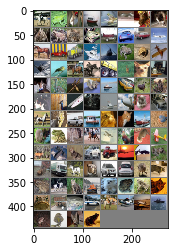

In [38]:
### show some img data, only work when trainloader has been declare

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

## build CNN

In [39]:
class CNN(nn.Module):
    def __init__(self, n_conv1_filter, n_conv2_filter):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(# input size(3, 32, 32)
            nn.Conv2d( 
                in_channels = 3, # RGB
                out_channels = n_conv1_filter, # num_filter
                kernel_size=5, # filter's height and width = 5
                stride=1, # shift 1 distance each time
                padding=2, # if stride=1, padding=(kernel_size-1)/2, filled with zero
            ),# -->(16, 32, 32)
            nn.ReLU(),# -->(16, 32, 32)
            nn.MaxPool2d(kernel_size=2,),# -->(16, 16, 16)
        )
        self.conv2 = nn.Sequential(# input size(16, 16, 16)
            nn.Conv2d(n_conv1_filter, n_conv2_filter, 5, 1, 2), #(in, out, kernel, strid, padding) # -->(32, 16, 16)
            nn.ReLU(),# -->(32, 16, 16)
            nn.MaxPool2d(2), # -->(32, 8, 8)
        )
        self.conv3 = nn.Sequential(# input size(32, 8, 8),8
            nn.Conv2d(n_conv2_filter, n_conv2_filter*2, 5, 1, 2), #(in, out, kernel, strid, padding) # -->(64, 8, 8)
            nn.ReLU(),# -->(64, 8, 8)
            nn.MaxPool2d(2), # -->(64, 4, 4
        )
        self.out = nn.Linear(n_conv2_filter * 2 * 4 * 4, 10) # 10 class
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [21]:
### evaluated data preparation
train_x = None
train_y = None
test_x = None
test_y = None

# train data

for itr, data in enumerate(trainloader):
    images, labels = data
    if itr==0:
        train_x = images
        train_y = labels
    else:
        train_x = torch.cat((train_x, images), dim=0)
        train_y = torch.cat((train_y, labels), dim=0)
    if itr ==99:
        break
print('train_x shape', train_x.size(), ' | train_y shape', train_y.size())
        
        
# test data

for itr, data in enumerate(testloader):
    images, labels = data
    if itr==0:
        test_x = images
        test_y = labels
    else:
        test_x = torch.cat((test_x, images), dim=0)
        test_y = torch.cat((test_y, labels), dim=0)

print('test_x shape', test_x.size(), ' | test_y shape', test_y.size())

train_x shape torch.Size([10000, 3, 32, 32])  | train_y shape torch.Size([10000])
test_x shape torch.Size([10000, 3, 32, 32])  | test_y shape torch.Size([10000])


In [40]:
result = {}

result['param_num'] = []
result['train_acc'] = []
result['test_acc'] = []
result['train_loss'] = []
result['test_loss'] = []

In [31]:
# training and validate 20 different model

for itr in range(1, 21, 1):

    num_filter = itr * 2 + 4
    
    # declare CNN model with num_filter
    cnn=CNN(n_conv1_filter = num_filter, n_conv2_filter = (num_filter*2))
#     print(cnn)

    # count parameters number
    param_num = 0

    for parameter in cnn.parameters(): # find each layer's parameter tensor
        param_each_layer = 1
        for dim in list(parameter.size()): # calculate parameter number
            param_each_layer *=dim

        param_num += param_each_layer # sum

    print('*** itr %d | param_num %d'% (itr, param_num)) # finally get number of parameters
    
    def training():
        optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
        loss_func = nn.CrossEntropyLoss()

        for epoch in range(EPOCH):
            for step, (x, y) in enumerate(trainloader):
#                 print(type(x),' | ' , type(y))
                b_x = Variable(x, requires_grad=True) # batch x
                b_y = Variable(y) # batch y

                output = cnn(b_x)
                loss = loss_func(output, b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                break
                
#########################################################                        
    
        ### train
#         train_loss
        train_loss = loss.data[0]
        # train_acc
        correct = 0
        total = 0
        
        outputs = cnn(Variable(train_x))
        predicted = torch.max(outputs, 1)[1].data.squeeze()
#         print("predicted ", predicted.size())
        total = train_x.size(0)
        correct = sum((predicted == train_y))
        train_acc = correct / total
        
        ### test
        outputs = cnn.forward(Variable(test_x))
        # test_loss
        test_loss = loss_func(outputs, Variable(test_y)).data[0]
        # test_acc
        predicted = torch.max(outputs, 1)[1].data.squeeze()
#         print("test predicted ", test_pred.size())
        total = test_x.size(0)
        correct = sum((predicted == test_y))
        test_acc = correct / total
    
#########################################################        

        ### record
        result['param_num'].append(round(param_num, 4))
        result['train_acc'].append(round(train_acc, 4))
        result['test_acc'].append(round(test_acc, 4))
        result['train_loss'].append(round(train_loss, 4))
        result['test_loss'].append(round(test_loss, 4))
        
        ### print
        print(
            'train_acc : %.4f' % train_acc,
            '\t test_acc : %.4f' % test_acc,
            '\t train_loss : %.4f' % train_loss,
            '\t test_loss : %.4f' % test_loss,
        )
        
#         del cnn
        
    training()

*** itr 1 | param_num 13342
train_acc : 0.1117 	 test_acc : 0.1142 	 train_loss : 2.2994 	 test_loss : 2.3574
*** itr 2 | param_num 21786
train_acc : 0.0992 	 test_acc : 0.1047 	 train_loss : 2.3086 	 test_loss : 2.6514
*** itr 3 | param_num 32230
train_acc : 0.1088 	 test_acc : 0.1177 	 train_loss : 2.3016 	 test_loss : 2.5571
*** itr 4 | param_num 44674
train_acc : 0.0994 	 test_acc : 0.1000 	 train_loss : 2.2977 	 test_loss : 3.9467
*** itr 5 | param_num 59118
train_acc : 0.0973 	 test_acc : 0.1000 	 train_loss : 2.3000 	 test_loss : 4.2824
*** itr 6 | param_num 75562
train_acc : 0.1000 	 test_acc : 0.1020 	 train_loss : 2.3079 	 test_loss : 3.3708
*** itr 7 | param_num 94006
train_acc : 0.0947 	 test_acc : 0.1000 	 train_loss : 2.2990 	 test_loss : 7.6307
*** itr 8 | param_num 114450
train_acc : 0.1018 	 test_acc : 0.1000 	 train_loss : 2.3054 	 test_loss : 6.1861
*** itr 9 | param_num 136894
train_acc : 0.0969 	 test_acc : 0.1026 	 train_loss : 2.3012 	 test_loss : 6.6980
*** itr 

KeyboardInterrupt: 

In [23]:
output = cnn(Variable(train_x))
output

Variable containing:
  4.7631  11.4677   9.0789  ...  -10.7692 -14.7761  16.1386
  6.3548  17.8308  14.5028  ...  -18.1655 -22.1960  24.6525
  5.6245  17.5180  14.9346  ...  -18.9301 -23.2849  24.7018
           ...               ⋱              ...            
  5.6712  17.3983  13.8715  ...  -16.9598 -22.1355  23.9554
  7.8725  17.7529  14.3291  ...  -19.6874 -25.4201  26.9401
  3.8752  12.5342  10.3897  ...  -12.2153 -16.0813  17.6643
[torch.FloatTensor of size 10000x10]

In [25]:
train_y


 7
 1
 9
⋮ 
 8
 6
 2
[torch.LongTensor of size 10000]